In [56]:
# =========================================
# Credit Risk Prediction - Model Training
# Multi-Model Comparison (LR, RF, XGB)
# =========================================

# ---------- 1. Imports ----------
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve


In [57]:

# ---------- 2. Load Data ----------
df = pd.read_csv("../data/german_credit_data.csv")


In [58]:

# ---------- 3. Data Cleaning ----------
df.drop(columns=["Unnamed: 0"], inplace=True)

df["Saving accounts"] = df["Saving accounts"].fillna("unknown")
df["Checking account"] = df["Checking account"].fillna("unknown")

df["Risk"] = df["Risk"].map({"good": 0, "bad": 1})


In [59]:

# ---------- 4. Features ----------
num_cols = ["Age", "Job", "Credit amount", "Duration"]
cat_cols = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]

X = df[num_cols + cat_cols]
y = df["Risk"]


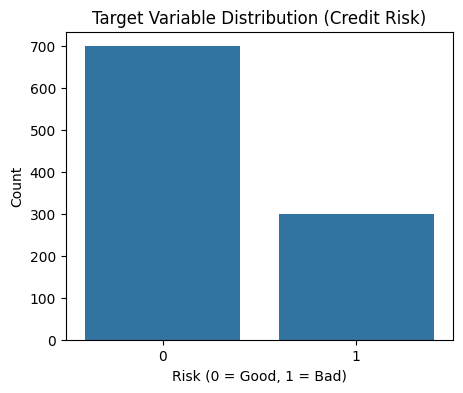

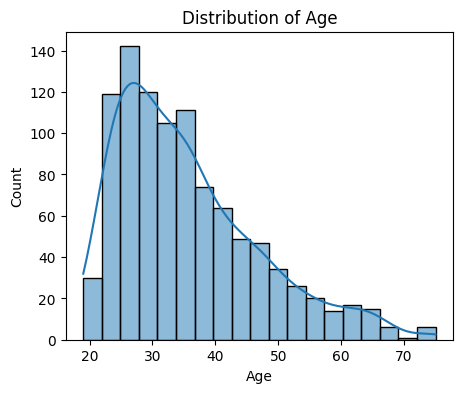

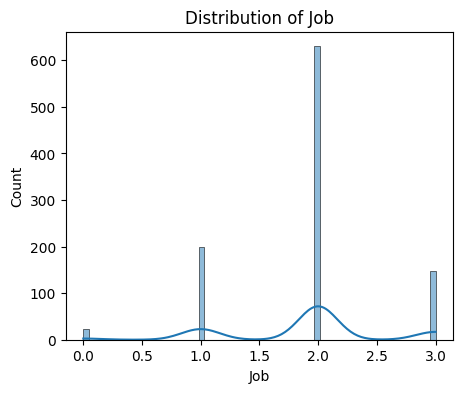

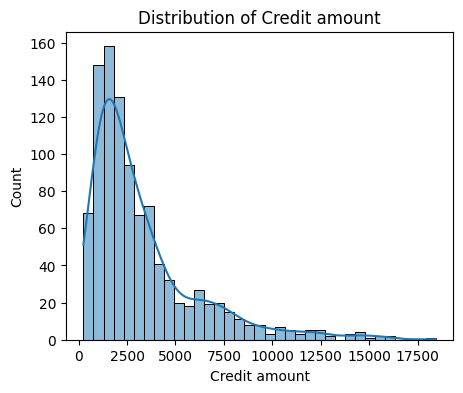

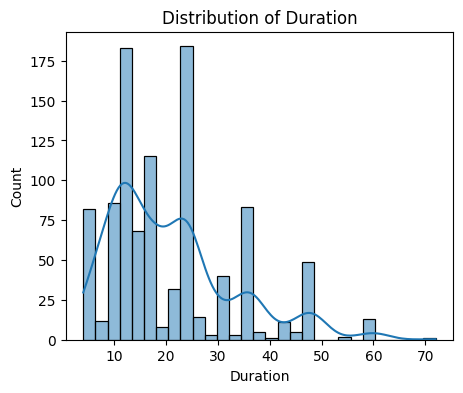

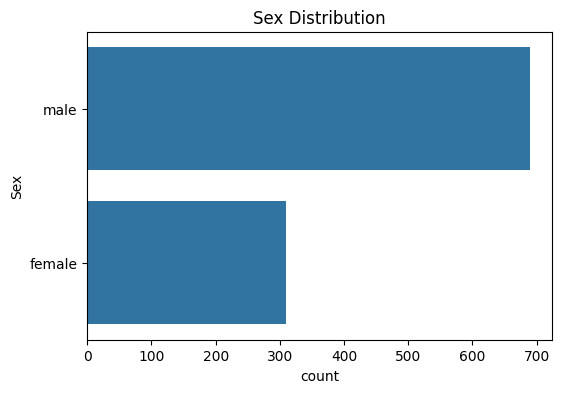

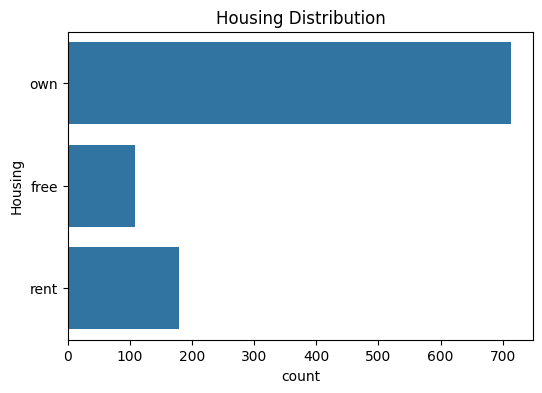

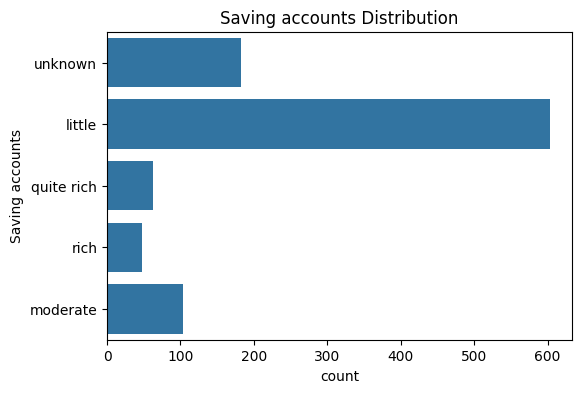

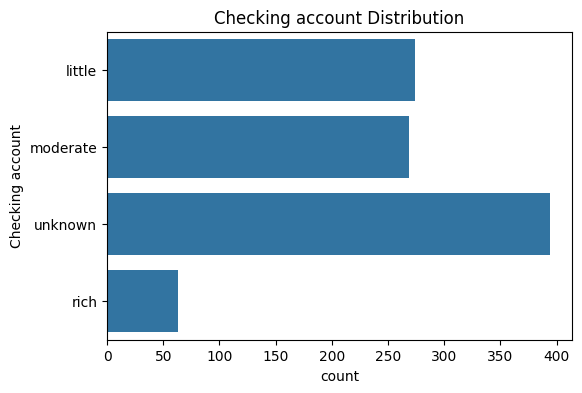

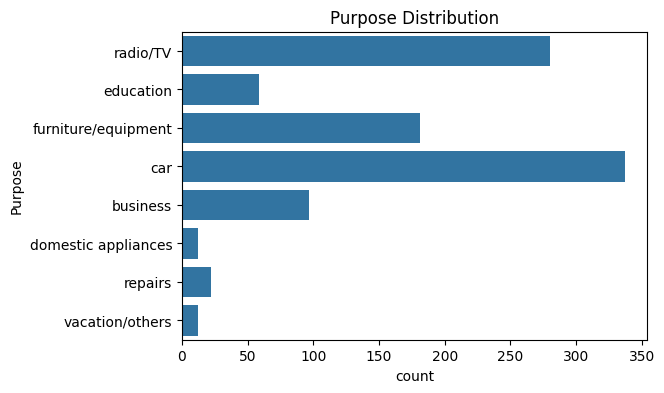

In [60]:
# =========================================
# EDA Visualizations
# =========================================

import seaborn as sns
import matplotlib.pyplot as plt

os.makedirs("../images/eda", exist_ok=True)

# --- Target distribution ---
plt.figure(figsize=(5,4))
sns.countplot(x=df["Risk"])
plt.title("Target Variable Distribution (Credit Risk)")
plt.xlabel("Risk (0 = Good, 1 = Bad)")
plt.ylabel("Count")
plt.savefig("../images/eda/target_distribution.png", bbox_inches="tight")
plt.show()
plt.close()

# --- Numerical feature distributions ---
for col in num_cols:
    plt.figure(figsize=(5,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.savefig(f"../images/eda/{col}_distribution.png", bbox_inches="tight")
    plt.show()
    plt.close()

# --- Categorical feature distributions ---
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=df[col])
    plt.title(f"{col} Distribution")
    plt.savefig(f"../images/eda/{col}_distribution.png", bbox_inches="tight")
    plt.show()
    plt.close()


In [61]:

# ---------- 5. Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [62]:

# ---------- 6. Preprocessing ----------
numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])


In [63]:

# ---------- 7. Models ----------
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        random_state=42
    )
}


In [64]:

# ---------- 8. Training & Evaluation ----------
results = []

trained_models = {}

roc_curves = {}


for name, model in models.items():
    print(f"\n===== Training {name} =====")

    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr)

    results.append({
        "Model": name,
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

    trained_models[name] = pipeline



===== Training Logistic Regression =====

===== Training Random Forest =====

===== Training XGBoost =====


In [65]:

# ---------- 9. Model Comparison ----------
results_df = pd.DataFrame(results).sort_values(
    by="ROC_AUC", ascending=False
)

print("\n===== Model Comparison =====")
print(results_df)

os.makedirs("../results", exist_ok=True)
results_df.to_csv("../results/model_comparison.csv", index=False)



===== Model Comparison =====
                 Model   ROC_AUC  Precision    Recall        F1
2              XGBoost  0.777500   0.524590  0.533333  0.528926
0  Logistic Regression  0.765476   0.493827  0.666667  0.567376
1        Random Forest  0.764762   0.513889  0.616667  0.560606


FileNotFoundError: [Errno 2] No such file or directory: '../images/models/roc_curves.png'

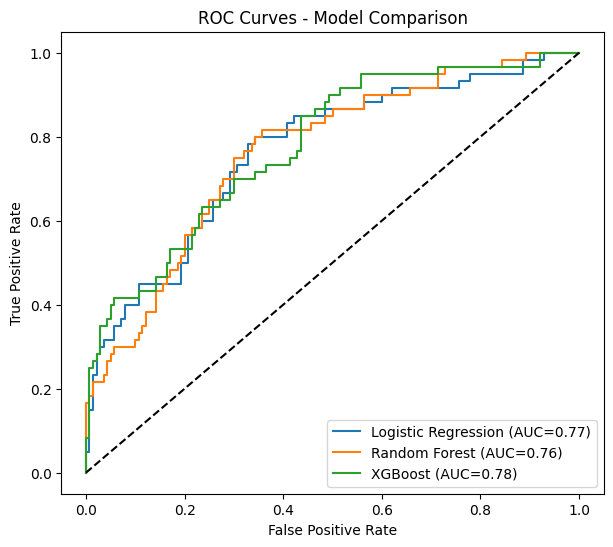

In [66]:
plt.figure(figsize=(7,6))

for model_name, (fpr, tpr) in roc_curves.items():
    auc_score = results_df.loc[
        results_df["Model"] == model_name, "ROC_AUC"
    ].values[0]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_score:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend()
plt.savefig("../images/models/roc_curves.png", bbox_inches="tight")
plt.show()
plt.close()

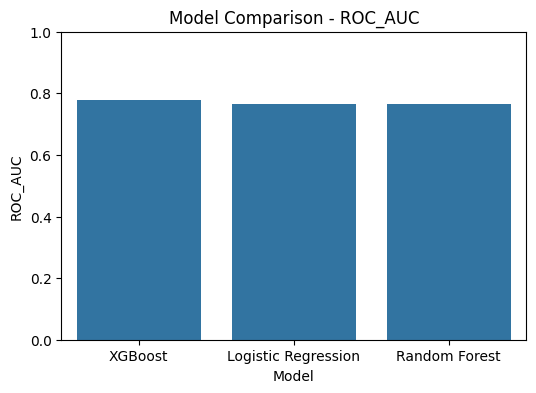

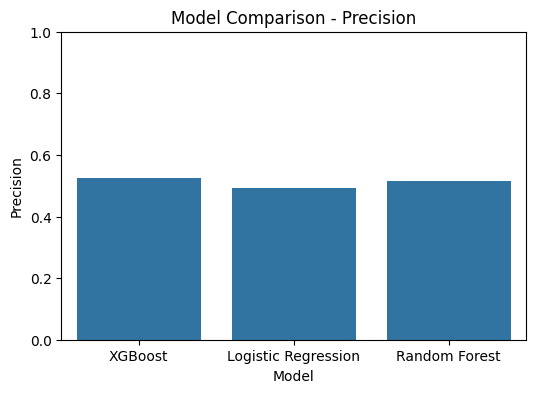

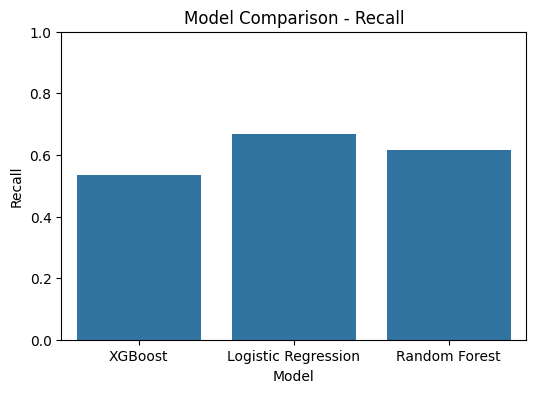

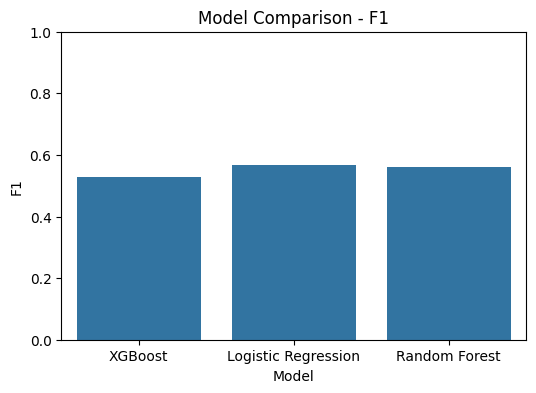

In [ ]:
# =========================================
# Model Comparison Visualizations
# =========================================

os.makedirs("../images/models", exist_ok=True)

metrics = ["ROC_AUC", "Precision", "Recall", "F1"]

for metric in metrics:
    plt.figure(figsize=(6,4))
    sns.barplot(
        data=results_df,
        x="Model",
        y=metric
    )
    plt.title(f"Model Comparison - {metric}")
    plt.ylim(0,1)
    plt.savefig(f"../images/models/{metric.lower()}_comparison.png", bbox_inches="tight")
    plt.show()
    plt.close()


In [ ]:

# ---------- 10. Select Best Model ----------
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print(f"\nBest Model Selected: {best_model_name}")



Best Model Selected: XGBoost


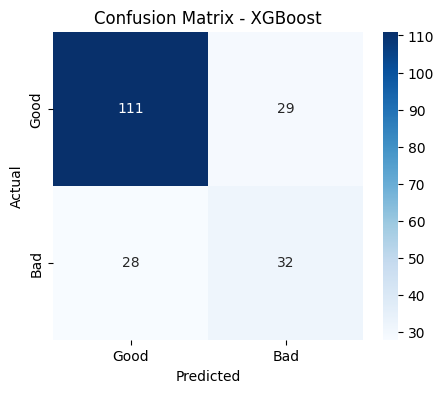

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Good", "Bad"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.savefig("../images/models/confusion_matrix.png", bbox_inches="tight")
plt.show()
plt.close()


In [ ]:

# ---------- 11. Save Best Model ----------
os.makedirs("../models", exist_ok=True)
joblib.dump(best_model, "../models/credit_risk_model.pkl")

print("Best model saved to ../models/credit_risk_model.pkl")


Best model saved to ../models/credit_risk_model.pkl


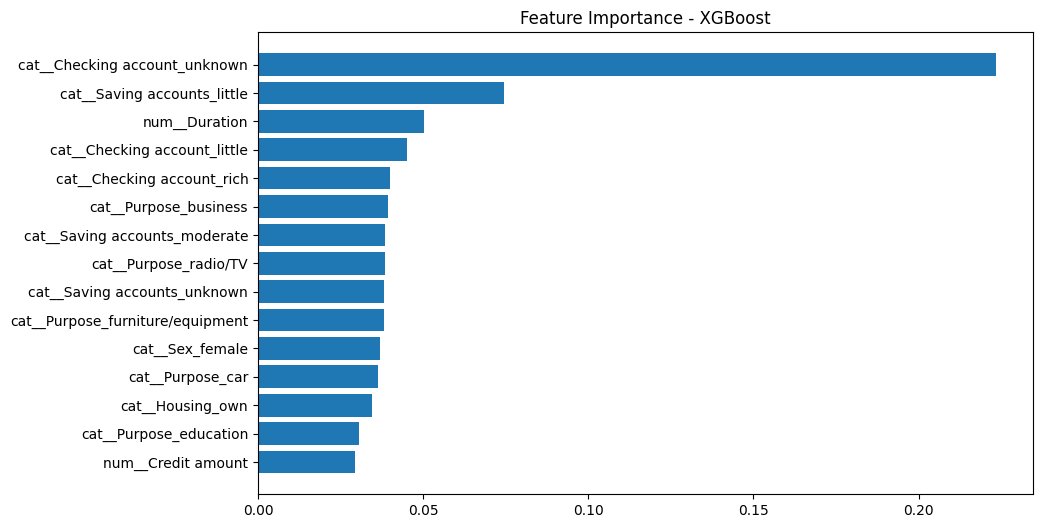

Training & comparison complete.


In [ ]:

# ---------- 12. Feature Importance (Tree Models Only) ----------
if best_model_name != "Logistic Regression":
    classifier = best_model.named_steps["classifier"]
    feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": classifier.feature_importances_
    }).sort_values(by="importance", ascending=False).head(15)

    os.makedirs("../images", exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"], importance_df["importance"])
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance - {best_model_name}")
    plt.savefig("../images/feature_importance.png", bbox_inches="tight")
    plt.show()
    plt.close()

print("Training & comparison complete.")
